In [ ]:
import sys, os, glob, time, imageio
import numpy as np, pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from PIL import Image

import torch
import torchvision.utils as vutils
import torchvision.transforms as transforms

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img


import tensorflow as tf
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:


# Root directory for dataset in Google Drive
google_drive_root = '/Users/adityadwivedi/Downloads/chest_xray'  # Replace 'MyDrive' with your folder structure
dataroot_train = os.path.join(google_drive_root, 'chest_xray', 'train')
dataroot_test = os.path.join(google_drive_root, 'chest_xray', 'test')
dataroot_val = os.path.join(google_drive_root, 'chest_xray', 'val')

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 40

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
def check_Image(path):
  try:
    im = Image.open(path)
    return True
  except:
    return False

In [ ]:
from PIL import Image
import numpy as np
import os

# Update filename with the path in Google Drive
filename = '/Users/adityadwivedi/Downloads/chest_xray/test/NORMAL/IM-0003-0001.jpeg'  # Replace 'MyDrive' with your folder structure

# Check if the file exists
if not os.path.exists(filename):
    raise FileNotFoundError(f"File not found: {filename}")

# open image using PIL
im = Image.open(filename)
im.show()

# convert to numpy array
img = np.array(im)

# find number of channels
if img.ndim == 2:
    channels = 1
    print("image has 1 channel")
else:
    channels = image.shape[-1]  # Assuming 'image' is defined elsewhere
    print("image has", channels, "channels")

    # Assuming 'test_images' is defined elsewhere
    # sample_image = test_images[0]

image has 1 channel


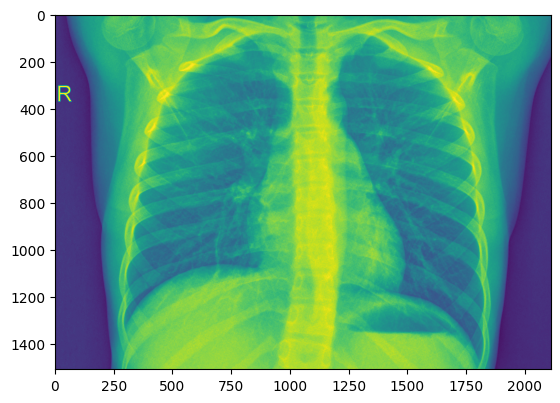

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread(filename))

In [ ]:
dataset_train = dset.ImageFolder(root=dataroot_train,
                           is_valid_file=check_Image,
                           transform=transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

dataset_test = dset.ImageFolder(root=dataroot_test,
                           is_valid_file=check_Image,
                           transform=transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

dataset_val = dset.ImageFolder(root=dataroot_val,
                           is_valid_file=check_Image,
                           transform=transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

In [ ]:
l = []
l.append(dataset_train)
l.append(dataset_test)
l.append(dataset_val)
image_datasets = torch.utils.data.ConcatDataset(l)

In [ ]:
dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


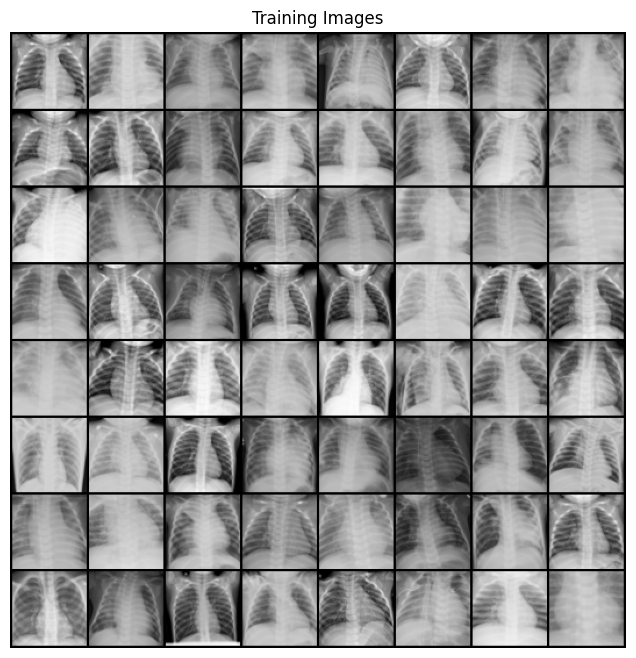

In [ ]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.seq_model = nn.Sequential(
            nn.ConvTranspose2d(in_channels = SIZE_OF_NOISE,
                               out_channels = SIZE_OF_FEATURE_MAP * 8,
                               kernel_size = 4,
                               stride = 1,
                               padding = 0,
                               bias=False),
            nn.BatchNorm2d(num_features = SIZE_OF_FEATURE_MAP * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.ConvTranspose2d(in_channels = SIZE_OF_FEATURE_MAP * 8,
                               out_channels = SIZE_OF_FEATURE_MAP * 4,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(num_features = SIZE_OF_FEATURE_MAP * 4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.ConvTranspose2d(in_channels = SIZE_OF_FEATURE_MAP * 4,
                               out_channels = SIZE_OF_FEATURE_MAP * 2,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(num_features = SIZE_OF_FEATURE_MAP * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.ConvTranspose2d(in_channels = SIZE_OF_FEATURE_MAP * 2,
                               out_channels = SIZE_OF_FEATURE_MAP,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(num_features = SIZE_OF_FEATURE_MAP),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.ConvTranspose2d(in_channels = SIZE_OF_FEATURE_MAP,
                               out_channels = NUM_CHANNELS,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias=False),
            nn.Tanh()
        )

    def forward(self, inputs):
        return self.seq_model(inputs)

In [ ]:
SIZE_OF_NOISE = 100
SIZE_OF_FEATURE_MAP = 64
NUM_CHANNELS = 1
# Create the generator
netG = Generator().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (seq_model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import numpy as np
from torch_fidelity import calculate_metrics


# Function to compute PSNR
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

# Function to compute SSIM
# def calculate_ssim(img1, img2):
#     img1 = img1.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to Numpy (BCHW to BHWC)
#     img2 = img2.cpu().numpy().transpose(0, 2, 3, 1)
#     ssim_value = np.mean([ssim(img1[i], img2[i], multichannel=True) for i in range(img1.shape[0])])
#     return ssim_value



from skimage.metrics import structural_similarity as ssim

def calculate_ssim(img1, img2):
    img1 = img1.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to Numpy (BCHW to BHWC)
    img2 = img2.cpu().numpy().transpose(0, 2, 3, 1)

    ssim_values = []
    for i in range(img1.shape[0]):
        height, width, _ = img1[i].shape
        min_dim = min(height, width)
        win_size = min(7, min_dim) if min_dim >= 3 else 3  # Ensure a minimum of 3x3 window

        ssim_val = ssim(
            img1[i],
            img2[i],
            win_size=win_size,
            data_range=1.0,   # Assuming pixel values are normalized to [0, 1]
            channel_axis=-1   # Explicitly set the axis for color channels
        )
        ssim_values.append(ssim_val)

    return np.mean(ssim_values)




# Function to compute FID
# def calculate_fid_score(real_images, fake_images):
#     real_images = real_images.cpu().numpy()
#     fake_images = fake_images.cpu().numpy()
#     # Calculate FID using torch_fidelity's calculate_metrics function
#     metrics = calculate_metrics([real_images, fake_images], batch_size=50, cuda=True)
#     return metrics['frechet_inception_distance']

def calculate_fid_score(real_images, fake_images):
    # """
    # Calculate the FID score between real and fake images using torch_fidelity.

    # Parameters:
    #     real_images (torch.Tensor): Real images (B, C, H, W) normalized to [0, 1].
    #     fake_images (torch.Tensor): Fake images (B, C, H, W) normalized to [0, 1].

    # Returns:
    #     float: The FID score.
    # """
    real_images = (real_images * 255).byte()  # Convert to [0, 255] range
    fake_images = (fake_images * 255).byte()

    # Save real and fake images as temporary folders
    import tempfile
    from torchvision.utils import save_image

    with tempfile.TemporaryDirectory() as real_dir, tempfile.TemporaryDirectory() as fake_dir:
        # Save images to their respective folders
        for i, img in enumerate(real_images):
            save_image(img.float() / 255.0, f"{real_dir}/real_{i}.png")
        for i, img in enumerate(fake_images):
            save_image(img.float() / 255.0, f"{fake_dir}/fake_{i}.png")

        # Calculate FID using the saved folders
        metrics = calculate_metrics(
            input1=real_dir,
            input2=fake_dir,
            cuda=torch.cuda.is_available(),
            fid=True  # Enable FID computation
        )
    return metrics["frechet_inception_distance"]


# Initialize lists to track metrics
fid_scores = []
psnr_scores = []
ssim_scores = []





img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                real_images = data[0].cpu()

            min_batch_size = min(real_images.size(0), fake.size(0))
            real_images = real_images[:min_batch_size]
            fake = fake[:min_batch_size]
            # Calculate PSNR
            psnr_score = calculate_psnr(real_images, fake)
            psnr_scores.append(psnr_score)

          # Calculate SSIM
            ssim_score = calculate_ssim(real_images, fake)
            ssim_scores.append(ssim_score)

            # Calculate FID
            fid_score = calculate_fid_score(real_images, fake)
            fid_scores.append(fid_score)

            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/40][0/46]	Loss_D: 1.7265	Loss_G: 2.1845	D(x): 0.5896	D(G(z)): 0.6036 / 0.1601


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmpdf5bbb54" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

[1/40][0/46]	Loss_D: 0.0256	Loss_G: 7.5884	D(x): 0.9856	D(G(z)): 0.0104 / 0.0010
[2/40][0/46]	Loss_D: 0.2287	Loss_G: 6.6493	D(x): 0.9315	D(G(z)): 0.0367 / 0.0046
[3/40][0/46]	Loss_D: 0.2987	Loss_G: 4.5776	D(x): 0.8326	D(G(z)): 0.0340 / 0.0175
[4/40][0/46]	Loss_D: 0.1034	Loss_G: 5.6453	D(x): 0.9431	D(G(z)): 0.0303 / 0.0067
[5/40][0/46]	Loss_D: 0.2307	Loss_G: 4.1678	D(x): 0.9132	D(G(z)): 0.1006 / 0.0284
[6/40][0/46]	Loss_D: 0.3563	Loss_G: 6.0319	D(x): 0.9570	D(G(z)): 0.2375 / 0.0069
[7/40][0/46]	Loss_D: 0.2256	Loss_G: 5.0924	D(x): 0.9135	D(G(z)): 0.1095 / 0.0111
[8/40][0/46]	Loss_D: 0.3645	Loss_G: 5.2735	D(x): 0.8839	D(G(z)): 0.1792 / 0.0106
[9/40][0/46]	Loss_D: 0.2480	Loss_G: 4.3009	D(x): 0.8786	D(G(z)): 0.0789 / 0.0318
[10/40][0/46]	Loss_D: 0.3058	Loss_G: 4.7173	D(x): 0.8930	D(G(z)): 0.1436 / 0.0233


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmp26a3oerc" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

[11/40][0/46]	Loss_D: 0.5956	Loss_G: 2.0138	D(x): 0.6554	D(G(z)): 0.0140 / 0.2595
[12/40][0/46]	Loss_D: 0.3326	Loss_G: 4.2404	D(x): 0.9350	D(G(z)): 0.1819 / 0.0332
[13/40][0/46]	Loss_D: 0.4577	Loss_G: 3.5257	D(x): 0.7457	D(G(z)): 0.0187 / 0.0698
[14/40][0/46]	Loss_D: 0.3642	Loss_G: 2.7940	D(x): 0.7648	D(G(z)): 0.0211 / 0.0979
[15/40][0/46]	Loss_D: 0.1773	Loss_G: 5.1161	D(x): 0.9369	D(G(z)): 0.0883 / 0.0134
[16/40][0/46]	Loss_D: 0.3620	Loss_G: 5.2485	D(x): 0.9465	D(G(z)): 0.2250 / 0.0124
[17/40][0/46]	Loss_D: 0.2121	Loss_G: 4.5713	D(x): 0.8791	D(G(z)): 0.0432 / 0.0263
[18/40][0/46]	Loss_D: 0.5953	Loss_G: 5.7667	D(x): 0.9804	D(G(z)): 0.3772 / 0.0121
[19/40][0/46]	Loss_D: 0.2155	Loss_G: 4.0609	D(x): 0.8893	D(G(z)): 0.0732 / 0.0472
[20/40][0/46]	Loss_D: 0.5200	Loss_G: 7.5687	D(x): 0.9640	D(G(z)): 0.3353 / 0.0028
[21/40][0/46]	Loss_D: 0.3173	Loss_G: 4.5736	D(x): 0.9100	D(G(z)): 0.1731 / 0.0203


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmpxwtvr5fb" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

[22/40][0/46]	Loss_D: 0.2028	Loss_G: 4.7512	D(x): 0.9122	D(G(z)): 0.0789 / 0.0215
[23/40][0/46]	Loss_D: 0.2604	Loss_G: 3.3907	D(x): 0.8956	D(G(z)): 0.1211 / 0.0662
[24/40][0/46]	Loss_D: 0.5302	Loss_G: 5.0052	D(x): 0.9237	D(G(z)): 0.3194 / 0.0146
[25/40][0/46]	Loss_D: 0.2589	Loss_G: 3.9731	D(x): 0.9387	D(G(z)): 0.1598 / 0.0325
[26/40][0/46]	Loss_D: 0.5174	Loss_G: 6.1117	D(x): 0.9245	D(G(z)): 0.3035 / 0.0103
[27/40][0/46]	Loss_D: 0.3345	Loss_G: 4.0444	D(x): 0.8962	D(G(z)): 0.1785 / 0.0369
[28/40][0/46]	Loss_D: 0.3022	Loss_G: 3.7637	D(x): 0.8680	D(G(z)): 0.1203 / 0.0447
[29/40][0/46]	Loss_D: 0.4394	Loss_G: 2.8370	D(x): 0.7053	D(G(z)): 0.0169 / 0.1101
[30/40][0/46]	Loss_D: 0.1925	Loss_G: 3.6781	D(x): 0.8835	D(G(z)): 0.0533 / 0.0528
[31/40][0/46]	Loss_D: 0.3477	Loss_G: 5.0654	D(x): 0.9617	D(G(z)): 0.2380 / 0.0160
[32/40][0/46]	Loss_D: 0.3916	Loss_G: 4.4525	D(x): 0.8965	D(G(z)): 0.1929 / 0.0339


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmp6g5juy6h" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

[33/40][0/46]	Loss_D: 0.1825	Loss_G: 4.1681	D(x): 0.8980	D(G(z)): 0.0604 / 0.0297
[34/40][0/46]	Loss_D: 0.4414	Loss_G: 5.7143	D(x): 0.9462	D(G(z)): 0.2793 / 0.0143
[35/40][0/46]	Loss_D: 0.2655	Loss_G: 3.8184	D(x): 0.9088	D(G(z)): 0.1375 / 0.0362
[36/40][0/46]	Loss_D: 0.1762	Loss_G: 3.9316	D(x): 0.9352	D(G(z)): 0.0956 / 0.0342
[37/40][0/46]	Loss_D: 0.2420	Loss_G: 3.9294	D(x): 0.8793	D(G(z)): 0.0764 / 0.0468
[38/40][0/46]	Loss_D: 0.5088	Loss_G: 4.3168	D(x): 0.6752	D(G(z)): 0.0375 / 0.0443
[39/40][0/46]	Loss_D: 0.2714	Loss_G: 4.5972	D(x): 0.9549	D(G(z)): 0.1846 / 0.0182


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmpb9lpl1bg" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

In [ ]:
print(ssim_scores)
print(psnr_scores)

[np.float32(-0.00294822), np.float32(0.105791315), np.float32(0.10173176), np.float32(0.11197312), np.float32(0.11004278)]
[6.620180130004883, 7.650959014892578, 8.067390441894531, 8.388958930969238, 8.257987976074219]


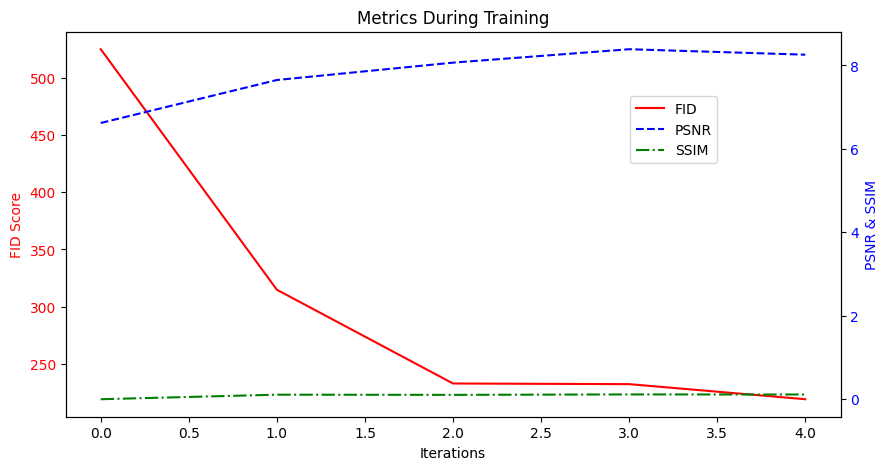

In [ ]:
import matplotlib.pyplot as plt

# Plot FID on the left y-axis
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_title("Metrics During Training")
ax1.plot(fid_scores, label="FID", color="red")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("FID Score", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Create a twin y-axis for PSNR and SSIM
ax2 = ax1.twinx()
ax2.plot(psnr_scores, label="PSNR", color="blue", linestyle="--")
ax2.plot(ssim_scores, label="SSIM", color="green", linestyle="-.")
ax2.set_ylabel("PSNR & SSIM", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Add legends for both y-axes
fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85), bbox_transform=ax1.transAxes)

plt.show()


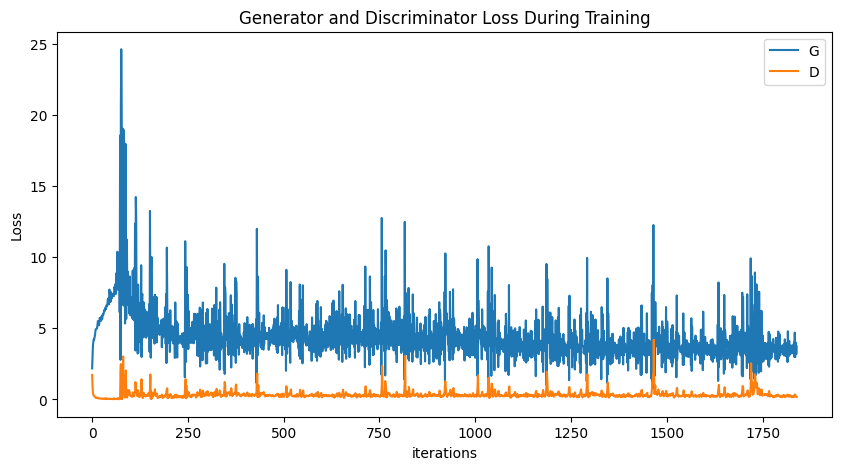

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

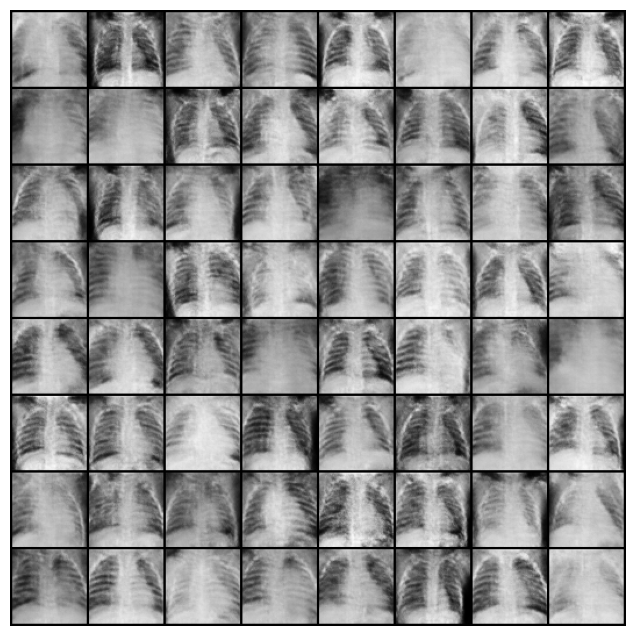

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())